In [ ]:
#!pip install torchsummary

In [2]:
import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

from scipy.spatial import distance_matrix

from torchsummary import summary

import random
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt

In [19]:
SEED=1
torch.manual_seed(SEED)
np.random.seed(SEED)
random.seed(SEED)

# Section 1 - traveling salesman

## 1.1 Solution with Q-function

Basic solution of travelling salesman problem with Q-function. Based on the search for the best order of nodes. We make the set of travels and each time we write down the price of the whole path.

In [72]:
def update_q(q, dist_mat, state, action, alpha=0.012, gamma=0.9):
    immed_reward =dist_mat[state,action]  
    delayed_reward = q[action,:].max()
    # Q(s,a) = Q(s,a) + alpha*[R(s,a) + gamma*max(Q(s',a')) - Q(s,a)]
    q[state,action] += alpha * (immed_reward + gamma * delayed_reward - q[state,action]) 
    return q


def find_the_best(coords, dist_mat, n_epochs=100):
    q = np.zeros([len(coords), len(coords)]) 
    epsilon = 1.
    for i in range(n_epochs): 
        traj = [0] 
        state = 0
        possible_actions = [dest for dest in range(len(coords)) if dest not in traj] 
        while possible_actions: 
            if random.random() < epsilon: 
                action = random.choice(possible_actions) 
            else:  
                best_action_index = q[state, possible_actions].argmax() 
                action = possible_actions[best_action_index] 
            q = update_q(q, dist_mat, state, action)
            traj.append(action)
            state = traj[-1] 
            possible_actions = [dest for dest in range(len(coords)) if dest not in traj] 
        action = 0
        q = update_q(q, dist_mat, state, action) 
    traj.append(0) 
    epsilon = 1. - i * 1/n_epochs
    traj = [0] 
    state = 0
    distance_travel = 0.
    possible_actions = [ dest for dest in range(n) if dest not in traj ] 
    while possible_actions: # until all destinations are visited 
        best_action_index = q[state, possible_actions].argmax() 
        action = possible_actions[best_action_index] 
        distance_travel += dist_mat[state, action] 
        traj.append(action) 
        state = traj[-1] 
        possible_actions = [dest for dest in range(len(coords)) if dest not in traj ] 
    # Back to the first node
    action = 0
    distance_travel += dist_mat[state, action] 
    traj.append(action) 
    print('Best trajectory found:') 
    print(' -> '.join([str(b) for b in traj])) 
    print(f'Distance Travelled: {-1*distance_travel}')
    return(traj)

def plot_the_best(traj):
    plt.scatter(coords[:,0],coords[:,1])
    for i in traj:
        plt.plot([coords[traj[i],0],coords[traj[i+1],0]],[coords[traj[i],1],coords[traj[i+1],1]])

Best trajectory found:
0 -> 1 -> 2 -> 3 -> 0
Distance Travelled: 1.10180146


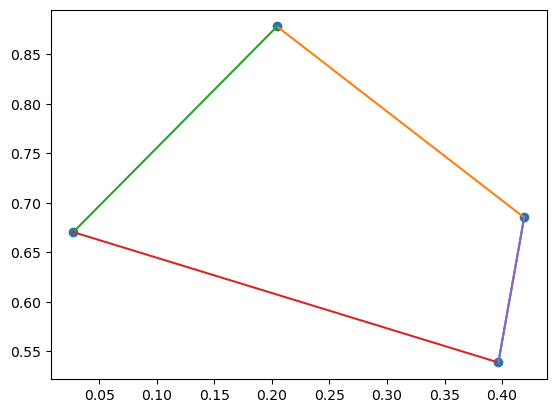

In [73]:
coords=np.array([[0.39676747, 0.53881673],
        [0.41919451, 0.6852195 ],
        [0.20445225, 0.87811744],
        [0.02738759, 0.67046751]])
dist_mat=np. array([[0.        , 0.14811057, 0.39001296, 0.39213955],
        [0.14811057, 0.        , 0.28865872, 0.39208454],
        [0.39001296, 0.28865872, 0.        , 0.27289262],
        [0.39213955, 0.39208454, 0.27289262, 0.        ]])
dist_mat=-1*dist_mat
n=4
traj=find_the_best(coords, dist_mat)
plot_the_best(traj)

Best trajectory found:
0 -> 1 -> 4 -> 2 -> 3 -> 0
Distance Travelled: 12.39834564


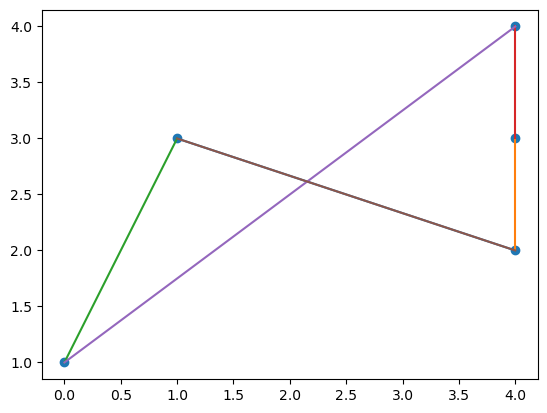

In [74]:
coords=np.array([[1, 3],
       [4, 2],
       [4, 4],
       [0, 1],
       [4, 3]])
dist_mat=np.array([[0.        , 3.16227766, 3.16227766, 2.23606798, 3.],
       [3.16227766, 0.        , 2.        , 4.12310563, 1.        ],
       [3.16227766, 2.        , 0.        , 5.        , 1.        ],
       [2.23606798, 4.12310563, 5.        , 0.        , 4.47213595],
       [3.        , 1.        , 1.        , 4.47213595, 0.        ]])
dist_mat=-1*dist_mat
n=5
traj=find_the_best(coords, dist_mat)
plot_the_best(traj)

Best trajectory found:
0 -> 2 -> 1 -> 17 -> 19 -> 3 -> 8 -> 11 -> 15 -> 6 -> 5 -> 4 -> 13 -> 18 -> 10 -> 9 -> 14 -> 16 -> 7 -> 12 -> 0
Distance Travelled: 4.0996915628806905


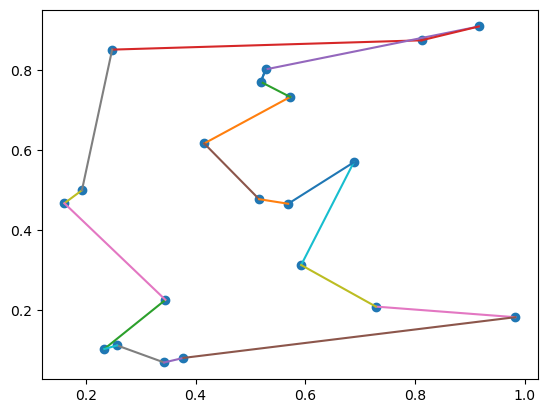

In [80]:
def get_graph_mat(n, size=1):
#    """ Throws n nodes uniformly at random on a square, and build a (fully connected) graph.
#        Returns the (N, 2) coordinates matrix, and the (N, N) matrix containing pairwise euclidean distances.
#    """
    coords = size * np.random.uniform(size=(n,2))
    dist_mat = distance_matrix(coords, coords)
    return coords, dist_mat
n=20
coords, dist_mat=get_graph_mat(n)
dist_mat*=-1
s=find_the_best(coords, dist_mat, n_epochs=1000)
plot_the_best(s)

# Solving with network

In [81]:
class RLnetwork(nn.Module):
    def __init__(self, hidden1_size, hidden2_size, 
                 hidden3_size, hidden4_size, n_points):
        super().__init__()
        self.layer1 = nn.Linear(1, hidden1_size)
        self.hidden1 = nn.Linear(hidden1_size, hidden2_size)
        self.hidden2 = nn.Linear(hidden2_size, hidden3_size)
        self.hidden3 = nn.Linear(hidden3_size, hidden4_size)
        self.hidden4 = nn.Linear(hidden4_size, hidden4_size)
        self.out = nn.Linear(hidden4_size, n_points)

    def forward(self,state):
        layer1 = self.layer1(state)
        layer2 = F.relu(self.hidden1(layer1))
        layer3 = F.relu(self.hidden2(layer2))
        layer4 = F.relu(self.hidden3(layer3))
        layer5 = F.relu(self.hidden4(layer4))
        output = self.out(layer5)
        return output

In [82]:
def plot_the_best(path):
    plt.scatter(coords[:,0],coords[:,1])
    for i in path:
        plt.plot([coords[path[i], 0], coords[path[i+1], 0]],
                 [coords[path[i], 1], coords[path[i+1], 1]])

In [86]:
n=5
model=RLnetwork(64,32,32,32,n)
#model=RLnetwork(5,10,n)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1. - 2e-5)

In [87]:
x=dict()
m=[]
coords=np.array([[1, 3],
       [4, 2],
       [4, 4],
       [0, 1],
       [4, 3]])
dist_mat=np.array([[0.        , 3.16227766, 3.16227766, 2.23606798, 3.],
       [3.16227766, 0.        , 2.        , 4.12310563, 1.        ],
       [3.16227766, 2.        , 0.        , 5.        , 1.        ],
       [2.23606798, 4.12310563, 5.        , 0.        , 4.47213595],
       [3.        , 1.        , 1.        , 4.47213595, 0.        ]])
dist_mat=-1*dist_mat

In [85]:
def train(model, optimizer, coords, dist_mat, n_epochs=1000):
    epsilon=1.
    history = []
    forrange = tqdm(range(n_epochs))
    for episode in forrange:
        state=0
        path=[state]
        q_s_a_loss=[]
        target_loss=[]

        for i in range(n-1):
            action_prob=model(torch.FloatTensor([state]))
            if epsilon > random.random():      
                q_s_a=random.choice(action_prob)
                action=action_prob.tolist().index(q_s_a)
                while action in path:
                    q_s_a=random.choice(action_prob)
                    action=action_prob.tolist().index(q_s_a)
                #print('action explore',action)         
            else:
                sorted_prob=action_prob.argsort(descending=True)
                #print('action_prob',action_prob,'sorted_prob',sorted_prob)
                for i in sorted_prob:
                    if i not in path:
                        action=i
                        q_s_a=action_prob[i]          
                        #print('action exploit',action)
                        #print('Q(',state,',',int(i),')','=',float(action_prob[i]))
                        break
            q_s_a_loss.append(q_s_a)
            next_action_prob=model(torch.FloatTensor([action]))
            sorted_prob=next_action_prob.argsort(descending=True)
            #print('next_action_prob',next_action_prob,'sorted_prob',sorted_prob)
            target=dist_mat[state,action]+0.9*next_action_prob[sorted_prob[0]]
            target_loss.append(target)
            #print('Q(',int(action),',',int(i),')','=',float(next_action_prob[i]))
            path.append(int(action))
            state=int(action)

        qloss=torch.stack(q_s_a_loss).sum()
        tloss=torch.stack(target_loss).sum()
        loss=F.mse_loss(qloss,tloss)
        loss.backward()
        #torch.autograd.set_detect_anomaly(True)
        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()

        epsilon=1-episode/n_episodes
        path.append(path[0])
        total_dist=0
        for i in range(len(path)-1):
            total_dist+=dist_mat[path[i],path[i+1]]
        forrange.set_description(f"total distance {-total_dist:.5f};")
        history.append(-total_dist)
        if episode==0:
            x[-total_dist]=path
            m.append(-total_dist)
        if episode>0:
            if -total_dist<m[-1]:
                x[-total_dist]=path
                m.append(-total_dist)
    #path=list(x.values())[-1]
    #plot_the_best(path) 
    plt.plot(history)
    plt.show()

total distance 12.35917;: 100%|██████████████████████████████████████████████████████| 100/100 [00:14<00:00,  6.70it/s]


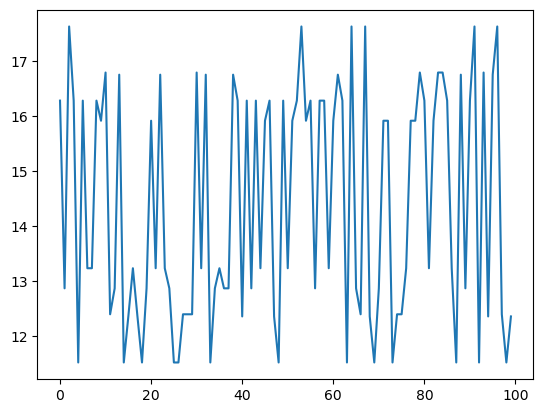

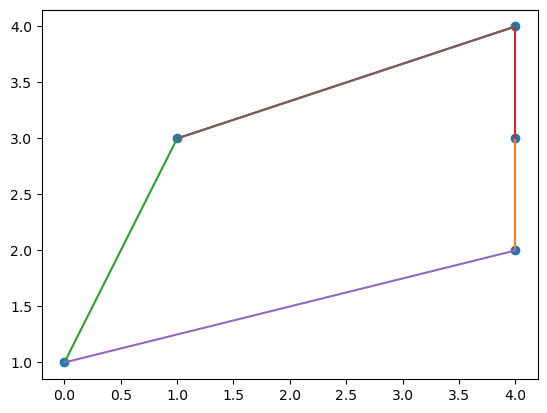

In [90]:
train(model, optimizer, coords, dist_mat, n_epochs=100)
path=list(x.values())[-1]
plot_the_best(path)

total distance 12.35917;: 100%|███████████████████████████████████████████████████| 1000/1000 [00:05<00:00, 172.67it/s]


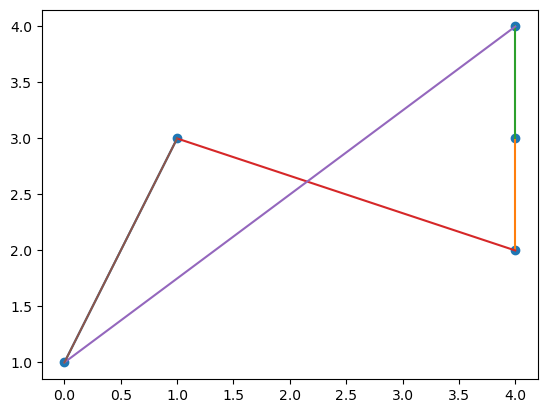

12.398345639999999


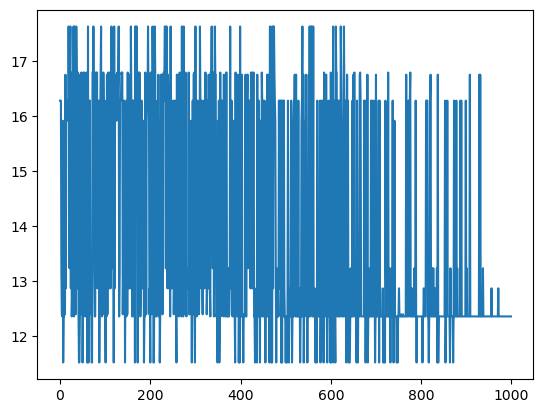

In [33]:
epsilon=1.
n_episodes=1000
history = []
forrange = tqdm(range(n_episodes))
for episode in forrange:
  state=0
  path=[state]
  q_s_a_loss=[]
  target_loss=[]

  for i in range(n-1):
    action_prob=model(torch.FloatTensor([state]))
    if epsilon > random.random():      
      q_s_a=random.choice(action_prob)
      action=action_prob.tolist().index(q_s_a)
      while action in path:
        q_s_a=random.choice(action_prob)
        action=action_prob.tolist().index(q_s_a)
      #print('action explore',action)         
    else:
      sorted_prob=action_prob.argsort(descending=True)
      #print('action_prob',action_prob,'sorted_prob',sorted_prob)
      for i in sorted_prob:
        if i not in path:
          action=i
          q_s_a=action_prob[i]          
          #print('action exploit',action)
          #print('Q(',state,',',int(i),')','=',float(action_prob[i]))
          break
    q_s_a_loss.append(q_s_a)
    
    next_action_prob=model(torch.FloatTensor([action]))
    sorted_prob=next_action_prob.argsort(descending=True)
    #print('next_action_prob',next_action_prob,'sorted_prob',sorted_prob)
    target=dist_mat[state,action]+0.9*next_action_prob[sorted_prob[0]]
    target_loss.append(target)

    
    #print('Q(',int(action),',',int(i),')','=',float(next_action_prob[i]))
    


    path.append(int(action))
    state=int(action)

  qloss=torch.stack(q_s_a_loss).sum()
  tloss=torch.stack(target_loss).sum()
  loss=F.mse_loss(qloss,tloss)
  loss.backward()
  #torch.autograd.set_detect_anomaly(True)
  optimizer.step()
  lr_scheduler.step()
  optimizer.zero_grad()

  epsilon=1-episode/n_episodes
  path.append(path[0])
  total_dist=0
  for i in range(len(path)-1):
    total_dist+=dist_mat[path[i],path[i+1]]
  forrange.set_description(f"total distance {-total_dist:.5f};")
  history.append(-total_dist)
  if episode==0:
    x[-total_dist]=path
    m.append(-total_dist)
  if episode>0:
    if -total_dist<m[-1]:
      x[-total_dist]=path
      m.append(-total_dist)


distance,path=list(x.keys())[-1],list(x.values())[-1]
plot_the_best(path)
plt.show()
print(distance)
plt.plot(history)
plt.show()

total distance 13.23607;: 100%|███████████████████████████████████████████████████| 8000/8000 [00:46<00:00, 171.53it/s]


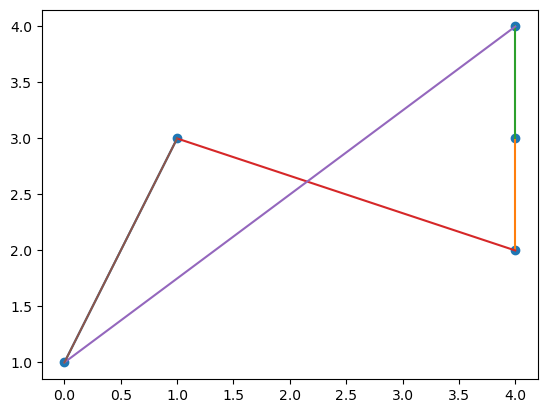

12.398345639999999


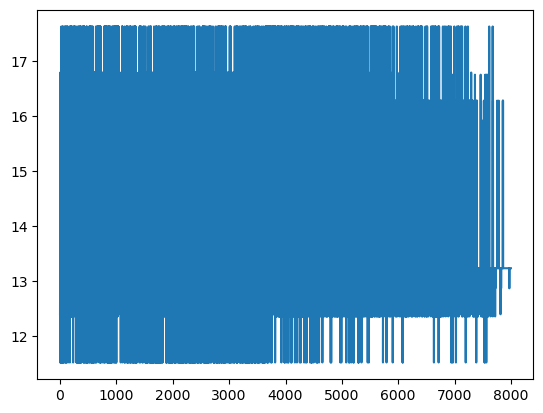

In [34]:
epsilon=1.
n_episodes=8000
history = []
forrange = tqdm(range(n_episodes))
for episode in forrange:
  state=0
  path=[state]
  q_s_a_loss=[]
  target_loss=[]

  for i in range(n-1):
    action_prob=model(torch.FloatTensor([state]))
    if epsilon > random.random():      
      q_s_a=random.choice(action_prob)
      action=action_prob.tolist().index(q_s_a)
      while action in path:
        q_s_a=random.choice(action_prob)
        action=action_prob.tolist().index(q_s_a)
      #print('action explore',action)         
    else:
      sorted_prob=action_prob.argsort(descending=True)
      #print('action_prob',action_prob,'sorted_prob',sorted_prob)
      for i in sorted_prob:
        if i not in path:
          action=i
          q_s_a=action_prob[i]          
          #print('action exploit',action)
          #print('Q(',state,',',int(i),')','=',float(action_prob[i]))
          break
    q_s_a_loss.append(q_s_a)
    
    next_action_prob=model(torch.FloatTensor([action]))
    sorted_prob=next_action_prob.argsort(descending=True)
    #print('next_action_prob',next_action_prob,'sorted_prob',sorted_prob)
    target=dist_mat[state,action]+0.9*next_action_prob[sorted_prob[0]]
    target_loss.append(target)

    
    #print('Q(',int(action),',',int(i),')','=',float(next_action_prob[i]))
    


    path.append(int(action))
    state=int(action)

  qloss=torch.stack(q_s_a_loss).sum()
  tloss=torch.stack(target_loss).sum()
  loss=F.mse_loss(qloss,tloss)
  loss.backward()
  #torch.autograd.set_detect_anomaly(True)
  optimizer.step()
  lr_scheduler.step()
  optimizer.zero_grad()

  epsilon=1-episode/n_episodes
  path.append(path[0])
  total_dist=0
  for i in range(len(path)-1):
    total_dist+=dist_mat[path[i],path[i+1]]
  forrange.set_description(f"total distance {-total_dist:.5f};")
  history.append(-total_dist)
  if episode==0:
    x[-total_dist]=path
    m.append(-total_dist)
  if episode>0:
    if -total_dist<m[-1]:
      x[-total_dist]=path
      m.append(-total_dist)

distance,path=list(x.keys())[-1],list(x.values())[-1]
plot_the_best(path)
plt.show()
print(distance)
plt.plot(history)
plt.show()

# Another thing

In [37]:
def tensor(ans):
  xv=[]
  for i in range(n):
    if i not in ans:
      xv.append([0,coords[i,0],coords[i,1]])
    else:
      xv.append([1,coords[i,0],coords[i,1]])
  xv=torch.FloatTensor(xv)
  xv=xv.unsqueeze(0)  
  return (xv)

In [38]:

class RLnetwork(nn.Module):
  def __init__(self,hidden1_size,hidden2_size,hidden3_size,hidden4_size,n):
    super().__init__()
    self.layer1=nn.Linear(3,hidden1_size)
    self.hidden1=nn.Linear(hidden1_size,hidden2_size)
    self.hidden2=nn.Linear(hidden2_size,hidden3_size)
    self.hidden3=nn.Linear(hidden3_size,hidden4_size)
    self.hidden4=nn.Linear(hidden4_size,hidden4_size)
    self.out=nn.Linear(hidden4_size,n)

  def forward(self,state):
    layer1=self.layer1(state)
    layer2=F.relu(self.hidden1(layer1))
    layer3=F.relu(self.hidden2(layer2))
    layer4=F.relu(self.hidden3(layer3))
    layer5=F.relu(self.hidden4(layer4))
    output=self.out(layer5)
    return output.sum(dim=1).squeeze(dim=0)


In [49]:
def find_the_best(n_episodes=100):
  loss=0
  epsilon=1.
  history = []
  forrange = tqdm(range(n_episodes))
  for episode in forrange:
    state=0
    path=[state]
    
    for i in range(n-1):
      if epsilon > random.random():
        action_prob=model(tensor(path))
        q_s_a=random.choice(action_prob)
        action=action_prob.tolist().index(q_s_a)
        while action in path:
          q_s_a=random.choice(action_prob)
          action=action_prob.tolist().index(q_s_a)
      else:
        action_prob=model(tensor(path))
        sorted_prob=action_prob.argsort(descending=True)
        for i in sorted_prob:
          if i not in path:
            action=i
            q_s_a=action_prob[i]
            break
      
      next_action_prob=model(tensor([action]))
      sorted_prob=next_action_prob.argsort(descending=True)
      target=dist_mat[state,action]+0.9*next_action_prob[sorted_prob[0]]

      loss=F.mse_loss(q_s_a,target)
      loss.backward(retain_graph=True)
      torch.autograd.set_detect_anomaly(True)
      optimizer.step()
      lr_scheduler.step()
      optimizer.zero_grad()
      path.append(int(action))
      state=int(action)

    epsilon=1-episode/n_episodes
    path.append(path[0])
    total_dist=0
    for i in range(len(path)-1):
      total_dist+=dist_mat[path[i],path[i+1]]
    forrange.set_description(f"total distance {-total_dist:.5f};")
    history.append(-total_dist)

    if episode==0:
      x[-total_dist]=path
      m.append(-total_dist)
    if episode>0:
      if -total_dist<m[-1]:
        x[-total_dist]=path
        m.append(-total_dist)
#     path=list(x.values())[-1]
#     plot_the_best(ans) 
  plt.title("distance history")
  plt.plot(history)
  plt.show()
  
  
  #return(path,total_dist)

In [50]:
def plot_the_best(ans):
  plt.scatter(coords[:,0],coords[:,1])
  for i in ans:
    plt.plot([coords[ans[i],0],coords[ans[i+1],0]],[coords[ans[i],1],coords[ans[i+1],1]])

In [51]:
#5 nodes
n=5
model=RLnetwork(64,32,32,32,n)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1. - 2e-5)

total distance 11.52145;: 100%|██████████████████████████████████████████████████████| 100/100 [00:15<00:00,  6.44it/s]


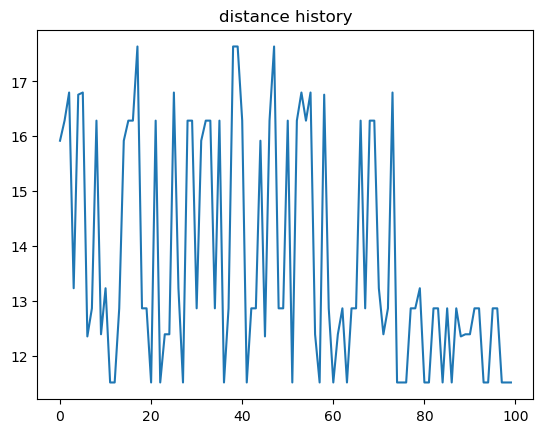

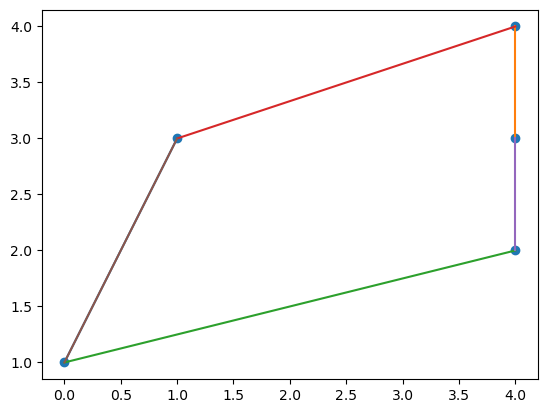

In [52]:
global x,m
x=dict()
m=[]
n=5
coords=np.array([[1, 3],
       [4, 2],
       [4, 4],
       [0, 1],
       [4, 3]])
dist_mat=np.array([[0.        , 3.16227766, 3.16227766, 2.23606798, 3.],
       [3.16227766, 0.        , 2.        , 4.12310563, 1.        ],
       [3.16227766, 2.        , 0.        , 5.        , 1.        ],
       [2.23606798, 4.12310563, 5.        , 0.        , 4.47213595],
       [3.        , 1.        , 1.        , 4.47213595, 0.        ]])
dist_mat*=-1



find_the_best(n_episodes=100)

ans=list(x.values())[-1]
plot_the_best(ans)

In [53]:
#20 nodes
n=20
model=RLnetwork(64,32,32,32,n)
optimizer = optim.Adam(model.parameters(), lr=5e-3)
lr_scheduler = optim.lr_scheduler.ExponentialLR(optimizer, gamma=1. - 2e-5)

total distance 8.94670;: 100%|███████████████████████████████████████████████████████| 400/400 [04:51<00:00,  1.37it/s]


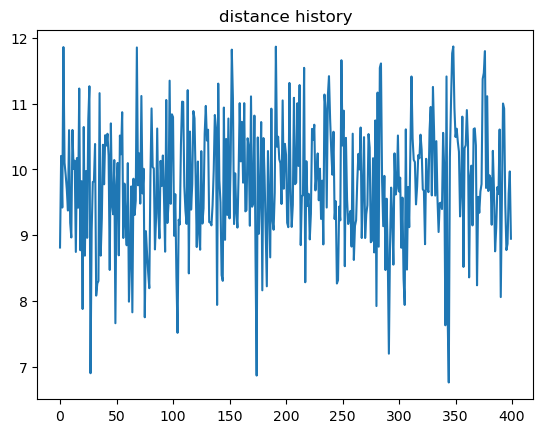

6.761331970000001


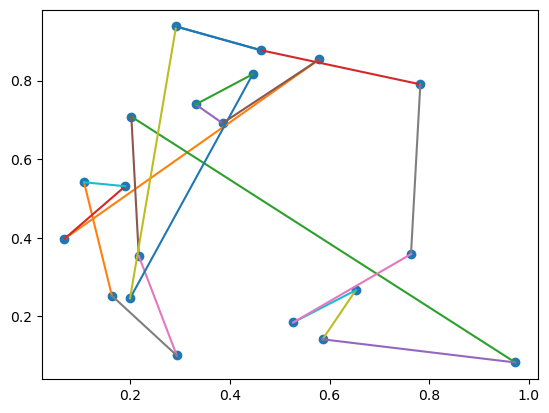

In [55]:
global x,m
m=[]
x=dict()
coords=np.array([[0.46220378, 0.87735237],
       [0.76336427, 0.35838996],
       [0.16299932, 0.25240311],
       [0.21695339, 0.35364676],
       [0.33120199, 0.73937273],
       [0.58597904, 0.14154071],
       [0.29175944, 0.93782709],
       [0.20197353, 0.7083501 ],
       [0.78209567, 0.79055844],
       [0.29320207, 0.10033818],
       [0.52681397, 0.18440201],
       [0.57909509, 0.85391278],
       [0.38499232, 0.69163824],
       [0.19942535, 0.24589808],
       [0.97274202, 0.08255818],
       [0.1897971 , 0.53120319],
       [0.10706641, 0.54124531],
       [0.6525935 , 0.26652373],
       [0.0676014 , 0.39721354],
       [0.44575475, 0.81648304]])
dist_mat=np.array([[-0.        , -0.60001635, -0.69288158, -0.57828654, -0.19026258,
        -0.74614952, -0.18085482, -0.31029269, -0.3314574 , -0.79518088,
        -0.69595595, -0.11921825, -0.20112521, -0.68394958, -0.94464125,
        -0.4404823 , -0.48896882, -0.63981237, -0.62148559, -0.06305272],
       [-0.60001635, -0.        , -0.6096485 , -0.54643148, -0.57611814,
        -0.2801591 , -0.74710006, -0.66153736, -0.43257423, -0.5363238 ,
        -0.2936458 , -0.5286757 , -0.50420209, -0.57504916, -0.34629786,
        -0.59903565, -0.68129507, -0.14390819, -0.69684521, -0.5574272 ],
       [-0.69288158, -0.6096485 , -0.        , -0.11472279, -0.5152005 ,
        -0.43726687, -0.69741322, -0.45760971, -0.82029961, -0.20019115,
        -0.37011518, -0.73140247, -0.49214671, -0.03700231, -0.82736361,
        -0.280085  , -0.29420794, -0.48979777, -0.17340941, -0.63098083],
       [-0.57828654, -0.54643148, -0.11472279, -0.        , -0.40229003,
        -0.42563941, -0.58895042, -0.35501951, -0.71433719, -0.26453563,
        -0.3530685 , -0.61758619, -0.37745903, -0.10916506, -0.80293554,
        -0.17962112, -0.21741289, -0.44426651, -0.1555766 , -0.51630174],
       [-0.19026258, -0.57611814, -0.5152005 , -0.40229003, -0.        ,
        -0.64985727, -0.20233598, -0.13289996, -0.45378969, -0.64016338,
        -0.58843568, -0.27307583, -0.07191649, -0.5107664 , -0.91813886,
        -0.25165433, -0.29915086, -0.57173305, -0.43192382, -0.13808814],
       [-0.74614952, -0.2801591 , -0.43726687, -0.42563941, -0.64985727,
        -0.        , -0.84890351, -0.68464087, -0.67800129, -0.29566197,
        -0.07305885, -0.71240533, -0.58566454, -0.40039258, -0.39123464,
        -0.55569503, -0.6237957 , -0.14162712, -0.57799997, -0.68935477],
       [-0.18085482, -0.74710006, -0.69741322, -0.58895042, -0.20233598,
        -0.84890351, -0.        , -0.24641672, -0.51197429, -0.83749015,
        -0.78924013, -0.29933824, -0.26325144, -0.69806256, -1.09326217,
        -0.41921273, -0.43747985, -0.76213478, -0.5852434 , -0.19605849],
       [-0.31029269, -0.66153736, -0.45760971, -0.35501951, -0.13289996,
        -0.68464087, -0.24641672, -0.        , -0.58591801, -0.61481798,
        -0.61647621, -0.40423899, -0.18378021, -0.46245904, -0.99282405,
        -0.1775649 , -0.19217537, -0.6310855 , -0.33891272, -0.26668711],
       [-0.3314574 , -0.43257423, -0.82029961, -0.71433719, -0.45378969,
        -0.67800129, -0.51197429, -0.58591801, -0.        , -0.84582561,
        -0.65771907, -0.21265702, -0.40923866, -0.79759615, -0.7332192 ,
        -0.64659318, -0.71959818, -0.53979921, -0.81561159, -0.33733856],
       [-0.79518088, -0.5363238 , -0.20019115, -0.26453563, -0.64016338,
        -0.29566197, -0.83749015, -0.61481798, -0.84582561, -0.        ,
        -0.24827655, -0.80598355, -0.59838216, -0.17315241, -0.67977252,
        -0.44309958, -0.47858707, -0.39595434, -0.37286812, -0.73221293],
       [-0.69595595, -0.2936458 , -0.37011518, -0.3530685 , -0.58843568,
        -0.07305885, -0.78924013, -0.61647621, -0.65771907, -0.24827655,
        -0.        , -0.67154895, -0.52668963, -0.33311421, -0.45741009,
        -0.48358187, -0.55093118, -0.15021474, -0.50612738, -0.63725743],
       [-0.11921825, -0.5286757 , -0.73140247, -0.61758619, -0.27307583,
        -0.71240533, -0.29933824, -0.40423899, -0.21265702, -0.80598355,
        -0.67154895, -0.        , -0.25299983, -0.71682005, -0.86599412,
        -0.50566234, -0.5661908 , -0.59196952, -0.6857113 , -0.13849416],
       [-0.20112521, -0.50420209, -0.49214671, -0.37745903, -0.07191649,
        -0.58566454, -0.26325144, -0.18378021, -0.40923866, -0.59838216,
        -0.52668963, -0.25299983, -0.        , -0.48282438, -0.84642083,
        -0.25266693, -0.31600766, -0.50232732, -0.43292366, -0.13884631],
       [-0.68394958, -0.57504916, -0.03700231, -0.10916506, -0.5107664 ,
        -0.40039258, -0.69806256, -0.46245904, -0.79759615, -0.17315241,
        -0.33311421, -0.71682005, -0.48282438, -0.        , -0.79037877,
        -0.28546752, -0.30945139, -0.45363729, -0.20068363, -0.62148642],
       [-0.94464125, -0.34629786, -0.82736361, -0.80293554, -0.91813886,
        -0.39123464, -1.09326217, -0.99282405, -0.7332192 , -0.67977252,
        -0.45741009, -0.86599412, -0.84642083, -0.79037877, -0.        ,
        -0.90237746, -0.97968778, -0.3692403 , -0.9582732 , -0.90352714],
       [-0.4404823 , -0.59903565, -0.280085  , -0.17962112, -0.25165433,
        -0.55569503, -0.41921273, -0.1775649 , -0.64659318, -0.44309958,
        -0.48358187, -0.50566234, -0.25266693, -0.28546752, -0.90237746,
        -0.        , -0.08333794, -0.53313762, -0.18134226, -0.38327394],
       [-0.48896882, -0.68129507, -0.29420794, -0.21741289, -0.29915086,
        -0.6237957 , -0.43747985, -0.19217537, -0.71959818, -0.47858707,
        -0.55093118, -0.5661908 , -0.31600766, -0.30945139, -0.97968778,
        -0.08333794, -0.        , -0.610796  , -0.14934068, -0.43642365],
       [-0.63981237, -0.14390819, -0.48979777, -0.44426651, -0.57173305,
        -0.14162712, -0.76213478, -0.6310855 , -0.53979921, -0.39595434,
        -0.15021474, -0.59196952, -0.50232732, -0.45363729, -0.3692403 ,
        -0.53313762, -0.610796  , -0.        , -0.5994127 , -0.58756916],
       [-0.62148559, -0.69684521, -0.17340941, -0.1555766 , -0.43192382,
        -0.57799997, -0.5852434 , -0.33891272, -0.81561159, -0.37286812,
        -0.50612738, -0.6857113 , -0.43292366, -0.20068363, -0.9582732 ,
        -0.18134226, -0.14934068, -0.5994127 , -0.        , -0.56461214],
       [-0.06305272, -0.5574272 , -0.63098083, -0.51630174, -0.13808814,
        -0.68935477, -0.19605849, -0.26668711, -0.33733856, -0.73221293,
        -0.63725743, -0.13849416, -0.13884631, -0.62148642, -0.90352714,
        -0.38327394, -0.43642365, -0.58756916, -0.56461214, -0.        ]])


find_the_best(n_episodes=400)

path=list(x.values())[-1]
plot_the_best(path)
print(list(x)[-1])

euclidean method: Total distance = 1046.7853240873421, Visited cities = [60, 21, 79, 80, 27, 59, 67, 37, 35, 42, 81, 88, 10, 41, 0, 90, 58, 7, 92, 24, 32, 22, 28, 43, 47, 86, 54, 14, 83, 55, 2, 49, 23, 1, 3, 45, 91, 61, 16, 85, 48, 95, 11, 99, 29, 19, 76, 94, 5, 56, 57, 52, 75, 69, 84, 82, 98, 39, 77, 25, 38, 17, 31, 68, 36, 26, 53, 50, 20, 89, 8, 64, 70, 97, 30, 51, 73, 40, 9, 34, 6, 65, 63, 15, 78, 4, 93, 96, 46, 87, 74, 33, 13, 72, 62, 66, 44, 12, 71, 18]
cityblock method: Total distance = 1361.0, Visited cities = [44, 56, 30, 0, 90, 15, 98, 69, 40, 42, 25, 7, 45, 89, 87, 6, 32, 59, 5, 71, 20, 86, 36, 48, 37, 52, 31, 60, 46, 51, 93, 22, 75, 62, 76, 91, 63, 53, 39, 80, 79, 1, 19, 84, 47, 23, 54, 78, 27, 16, 92, 68, 70, 88, 85, 28, 2, 13, 99, 94, 55, 82, 35, 96, 9, 61, 72, 83, 57, 73, 17, 64, 38, 29, 43, 66, 18, 11, 26, 34, 49, 77, 58, 12, 33, 50, 74, 65, 81, 95, 10, 21, 41, 8, 67, 4, 14, 3, 24, 97]


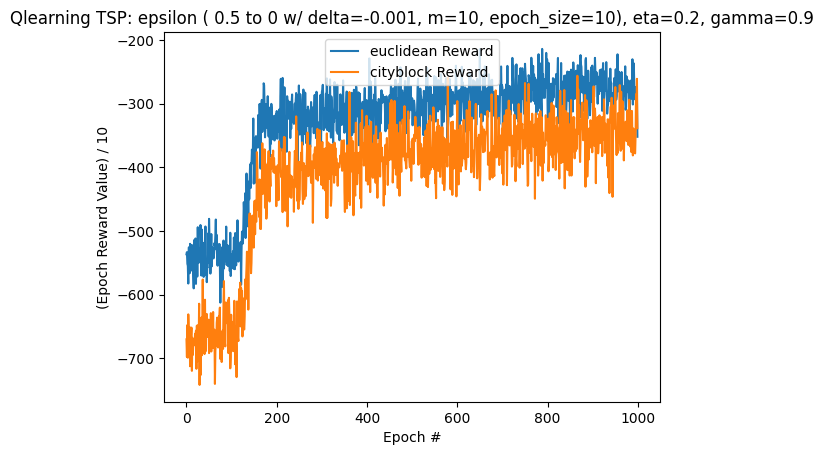

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.spatial.distance import cdist
import pandas as pd

MAP_SIZE = 100
N_CITIES = 100
N_EPOCHS = 1000
EPOCH_SIZE = 10         # how many games to play per training epoch
METHODS = ["euclidean", "cityblock"]
INIT_EPSILON = 0.5      # probability of choosing a random action
EPSILON_MIN =  0        # when to stop decreasing epsilon by delta
E_DELTA = 0.001         # how much to change epsilon by ever M epochs
M = 10                  # number of epochs to pass before decreasing epsilon
ETA = 0.2               # learning rate
GAMMA = 0.9             # discount factor

def generate_city_coords(env_data):
  """
  generate N_CITIES cities with coordinates being integer values
  representing the horizontal and vertical cells within the map grid
  with height and width equal to MAP_SIZE
  """
  c = np.random.randint(100, size=(N_CITIES, 2))
  env_data["x_coords"] = c[:,0]
  env_data["y_coords"] = c[:,1]

def generate_q_vals(env_data):
  """
  populates env["q_cities"] with q values for the cities based on the method
  or heuristic in use
  assumes valid method that is present in METHODS is provided
  the method will be provided directly to cdist, so it must also be a valid
  parameter for that function.
  methods such as euclidean and manhattan (cityblock) distance work
  """
  # given x and y coords lists, column_stack generates a list of lists
  # of the [[x,y],..] coordinate pairs
  c = np.column_stack([env_data["x_coords"], env_data["y_coords"]])
  env_data["q_cities"] = cdist(c, c, env_data["method"])

def reset_cities(env_data):
  """
  replaces env_data["cities"] with an empty list, appends a random city id to it
  and retuns it
  """
  env_data["cities"] = []
  first_city_id = np.random.randint(N_CITIES)  # pick a random city for start
  env_data["cities"].append(first_city_id)
  return first_city_id

def get_action(agent_data, start_city):
  """
  either picks the best city out of the q-vector for that starting city
  or picks a random city from the non-visited ones
  and returns that city index as the action
  """
  q_vector = np.copy(agent_data["qmatrix"][start_city,:])
  visited = agent_data["states"]
  q_vector[visited] = -np.inf  # don't visit already visted cities
  if np.random.rand() > agent_data["epsilon"]:
    action = np.argmax(q_vector)  # best action index with highest q value
  else:  # otherwise, choose random non-visited action
    action = np.random.choice([x for x in range(q_vector.size) if x not in visited])
  return action

def do_action(env_data, next_city):
  """
  gets the current city
  appends the provided next city to the list of cities (state) in this env
  gets the reward value for the trip between the current city and the next one
  returns the reward
  """
  cur_city = env_data["cities"][-1]  # last city appended
  env_data["cities"].append(next_city) # append new_city to cities visited
  r = env_data["q_cities"][cur_city, next_city]
  return r

def train(agent_data, state, action, reward):
  """
  trains an agent with agent data:
  updates q matrix of the agent with newly calculated value for that
  state,action pair based on the formula for q learning
  next_state is action because we have encoded actions as the list of city
  indexes
  """
  next_state = action
  agent_data["qmatrix"][state, action] = \
    agent_data["qmatrix"][state, action] + ETA * (reward + \
      GAMMA * np.max(agent_data["qmatrix"][next_state, action]) - \
      agent_data["qmatrix"][state, action])

def run_training_epoch(env_data, agent_data):
  i = 0
  epoch_r = 0
  done = False
  start_city = reset_cities(env_data)
  agent_data["states"] = []
  while i < env_data["n_cities"] and not done:
    agent_data["states"].append(start_city)
    action = get_action(agent_data, start_city)  # next city to visit
    r = do_action(env_data, action)  # expected reward for doing so
    done = len(env_data["cities"]) == env_data["n_cities"]
    r = -1 * r
    train(agent_data, start_city, action, r)
    epoch_r += r
    start_city = action
    i += 1
  return epoch_r

def run_n_epochs(env_data, agent_data, n_epochs=1000):
  """
  runs n_epochs training epochs for agent with provided agent and environment
  data
  returns the modified environment, agent and a list of the rewards for
  the entire training period
  """
  rewards = []
  for i in range(n_epochs):
    rewards.append(run_training_epoch(env_data, agent_data))
    if i > 0 and i % M == 0:  # decrease epsilon by delta every M epochs
      agent_data["epsilon"] -= E_DELTA
  return rewards
  

def test_agent(env_data, agent_data):
  start_city = np.random.randint(env_data["n_cities"])
  visited_cities = [start_city]
  total_distance = 0
  for _ in range(env_data["n_cities"] - 1):
    current_city = visited_cities[-1]
    q_values = agent_data["qmatrix"][current_city, :]
    q_values[visited_cities] = -np.inf  # ignore visited cities

    next_city = np.argmax(q_values)

    visited_cities.append(next_city)

    total_distance += env_data["q_cities"][current_city, next_city]

  return total_distance, visited_cities


def plot_stats(rewards):
  """
  plots both rewards for each iteration of both methods
  """
  columns = ['Epoch']
  stats = []
  columns.append(METHODS[0])
  columns.append(METHODS[1])
  i = 0
  for r in rewards[METHODS[0]]:
    stats.append([
      i,
      rewards[METHODS[0]][i]/EPOCH_SIZE,
      rewards[METHODS[1]][i]/EPOCH_SIZE])
    i += 1
  df = pd.DataFrame(stats, columns=columns)
  plt.title("Qlearning TSP: " +
            "epsilon ( {} to 0 w/ delta=-{}, m={}, epoch_size={}), ".format(
            INIT_EPSILON, E_DELTA, M, EPOCH_SIZE) + "eta={}, gamma={}".format(
            ETA, GAMMA))
  plt.xlabel("Epoch #")
  plt.ylabel("(Epoch Reward Value) / {}".format(EPOCH_SIZE))
  plt.plot(df["Epoch"], df[METHODS[0]], label='{} Reward'.format(METHODS[0]))
  plt.plot(df["Epoch"], df[METHODS[1]], label='{} Reward'.format(METHODS[1]))
  plt.legend(loc='upper center')
  plt.show()

def main():
  """
  entry point of program
  runs qlearning training with two different methods, records the rewards
  per epoch for each method and graphs them for comparison
  """
  rewards = {}
  for method in METHODS:
    env_data = {
      "n_cities" : N_CITIES,
      "method" : method,
      "x_coords" : [],
      "y_coords" : [],
      "q_cities" : [],
      "cities" : [],
    }
    tsp_qagent_data = {
     "states_size" : N_CITIES,
     "actions_size" : N_CITIES,
     "epsilon" : INIT_EPSILON,
     "qmatrix" : np.zeros([N_CITIES, N_CITIES]),
     "states" : []
    }
    generate_city_coords(env_data)
    generate_q_vals(env_data)
    reset_cities(env_data)
    rewards[method] = run_n_epochs(env_data, tsp_qagent_data, N_EPOCHS)
    
    total_distance, visited_cities = test_agent(env_data, tsp_qagent_data)
    print(f"{method} method: Total distance = {total_distance}, Visited cities = {visited_cities}")
  plot_stats(rewards)


if __name__ == "__main__":
  main()